## Homework 4

Lucrezia Rossi  
Matricola 2122164

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal, uniform, norm
import math
from tqdm import tqdm

#### Common Setup for Sampling and Analysis

In [2]:
# === COMMON SETUP  ===
np.random.seed(42)

mu = np.array([4, 2])
sigma = np.array([[1.44, -0.72], [-0.72, 0.81]])

joint_mvn = multivariate_normal(mu, sigma)

# Marginals
marginal_x = norm(loc=mu[0], scale=np.sqrt(sigma[0, 0]))
marginal_y = norm(loc=mu[1], scale=np.sqrt(sigma[1, 1]))

# Conditional distributions
def cond_x(given_y):
    mu_x = mu[0] + sigma[0, 1] / sigma[1, 1] * (given_y - mu[1])
    var_x = sigma[0, 0] - sigma[0, 1]**2 / sigma[1, 1]
    return norm(loc=mu_x, scale=np.sqrt(var_x))

def cond_y(given_x):
    mu_y = mu[1] + sigma[1, 0] / sigma[0, 0] * (given_x - mu[0])
    var_y = sigma[1, 1] - sigma[1, 0]**2 / sigma[0, 0]
    return norm(loc=mu_y, scale=np.sqrt(var_y))

# Credible interval
def credible_interval(data, level=0.95):
    low = np.quantile(data, (1 - level) / 2)
    high = np.quantile(data, 1 - (1 - level) / 2)
    return low, high

# True multivariate normal (for validation and plotting)
true_dist = multivariate_normal(mean=mu, cov=sigma)

def plot_joint_contour(samples, title="Sampled Contour", ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    sns.kdeplot(x=samples[:,0], y=samples[:,1], fill=True, cmap='viridis', levels=30, ax=ax)
    ax.set_xlabel('$X_1$')
    ax.set_ylabel('$X_2$')
    ax.set_title(title)
    ax.grid(True)

def plot_marginals(samples, method_name):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    sns.kdeplot(samples[:, 0], ax=axs[0], fill=True)
    axs[0].set_title(f"Marginal of $X_1$ ({method_name})")

    sns.kdeplot(samples[:, 1], ax=axs[1], fill=True)
    axs[1].set_title(f"Marginal of $X_2$ ({method_name})")

    plt.tight_layout()
    plt.show()


###  Posterior Analysis of a Bivariate Gaussian

Consider a bivariate Gaussian distribution $ \mathcal{N}(\mu, \Sigma) $ with:

$$
\mu = \begin{bmatrix} 4 \\ 2 \end{bmatrix}, \quad
\Sigma = \begin{bmatrix}
1.44 & -0.72 \\
-0.72 & 0.81
\end{bmatrix}
$$

The contours of the joint distribution $ p(X_1, X_2) $ illustrate the density levels of the 2D Gaussian. Due to the negative covariance, the contours take the shape of tilted ellipses aligned along a negatively sloped axis.


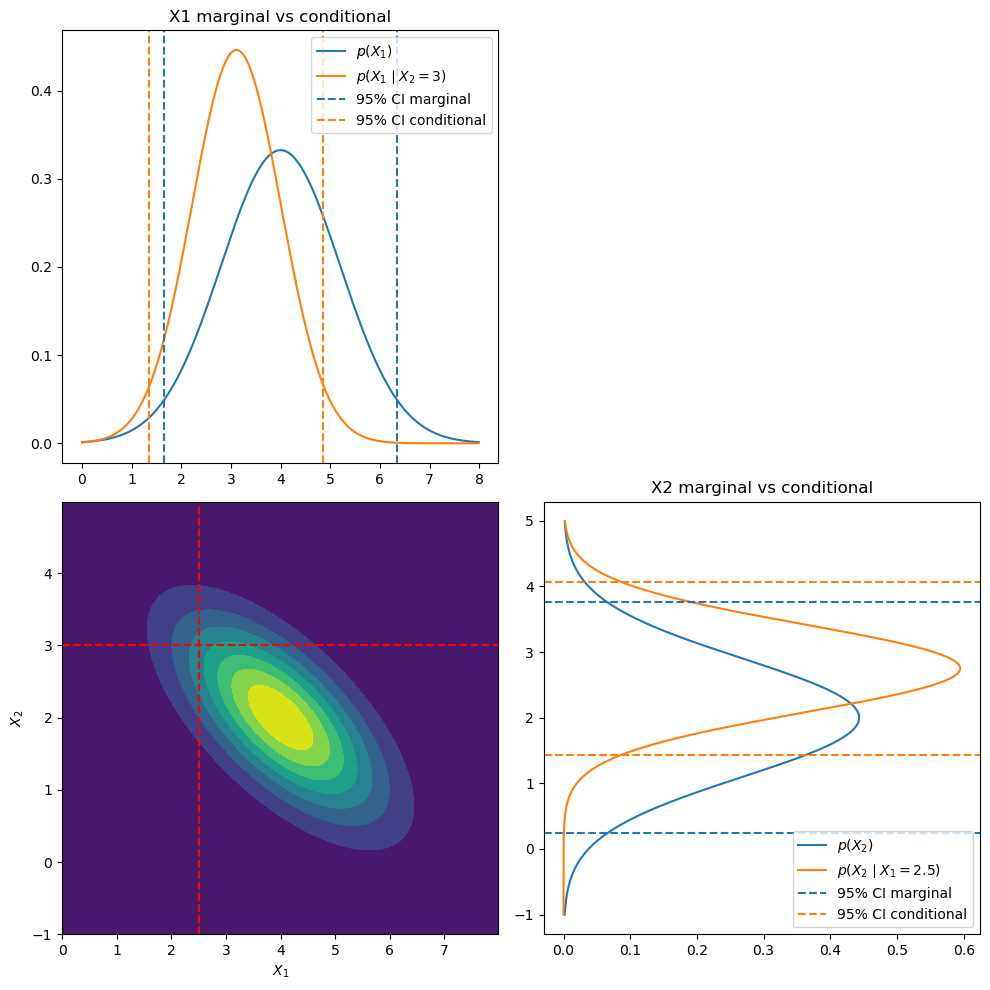

In [3]:
# Values for conditional plots
given_y = 3
given_x = 2.5
conditional_x = cond_x(given_y)
conditional_y = cond_y(given_x)

# Compute 95% credible intervals (±1.96σ)
ci_marginal_x = norm.interval(0.95, loc=marginal_x.mean(), scale=marginal_x.std())
ci_marginal_y = norm.interval(0.95, loc=marginal_y.mean(), scale=marginal_y.std())
ci_conditional_x = norm.interval(0.95, loc=conditional_x.mean(), scale=conditional_x.std())
ci_conditional_y = norm.interval(0.95, loc=conditional_y.mean(), scale=conditional_y.std())

# Plotting
x, y = np.mgrid[0:8:.01, -1:5:.01]
pos = np.dstack((x, y))

fig = plt.figure(figsize=(10, 10))

# Contour of joint distribution
ax = fig.add_subplot(223)
ax.contourf(x, y, joint_mvn.pdf(pos), cmap='viridis')
ax.axvline(given_x, color='r', linestyle='--')
ax.axhline(given_y, color='r', linestyle='--')
ax.set_xlabel(r'$X_1$')
ax.set_ylabel(r'$X_2$')

# Marginal and conditional for X1
ax = fig.add_subplot(221)
ax.plot(x[:, 0], marginal_x.pdf(x[:, 0]), label=r'$p(X_1)$')
ax.plot(x[:, 0], conditional_x.pdf(x[:, 0]), label=fr'$p(X_1 \mid X_2={given_y})$')
ax.axvline(ci_marginal_x[0], linestyle='--', color='tab:blue', label='95% CI marginal')
ax.axvline(ci_marginal_x[1], linestyle='--', color='tab:blue')
ax.axvline(ci_conditional_x[0], linestyle='--', color='tab:orange', label='95% CI conditional')
ax.axvline(ci_conditional_x[1], linestyle='--', color='tab:orange')
ax.set_title("X1 marginal vs conditional")
ax.legend()

# Marginal and conditional for X2
ax = fig.add_subplot(224)
ax.plot(marginal_y.pdf(y[0, :]), y[0, :], label=r'$p(X_2)$')
ax.plot(conditional_y.pdf(y[0, :]), y[0, :], label=fr'$p(X_2 \mid X_1={given_x})$')
ax.axhline(ci_marginal_y[0], linestyle='--', color='tab:blue', label='95% CI marginal')
ax.axhline(ci_marginal_y[1], linestyle='--', color='tab:blue')
ax.axhline(ci_conditional_y[0], linestyle='--', color='tab:orange', label='95% CI conditional')
ax.axhline(ci_conditional_y[1], linestyle='--', color='tab:orange')
ax.set_title("X2 marginal vs conditional")
ax.legend()

plt.tight_layout()
plt.show()



In [4]:
# Print 95% credible interval boundaries
print(" Marginal 95% credible intervals:")
print(f"  X1: [{ci_marginal_x[0]:.3f}, {ci_marginal_x[1]:.3f}]")
print(f"  X2: [{ci_marginal_y[0]:.3f}, {ci_marginal_y[1]:.3f}]")

print("\n Conditional 95% credible intervals:")
print(f"  X1 | X2 = {given_y}: [{ci_conditional_x[0]:.3f}, {ci_conditional_x[1]:.3f}]")
print(f"  X2 | X1 = {given_x}: [{ci_conditional_y[0]:.3f}, {ci_conditional_y[1]:.3f}]")


 Marginal 95% credible intervals:
  X1: [1.648, 6.352]
  X2: [0.236, 3.764]

 Conditional 95% credible intervals:
  X1 | X2 = 3: [1.358, 4.864]
  X2 | X1 = 2.5: [1.435, 4.065]


When conditioning, the standard deviation is always smaller or equal to the standard deviation obtained after marginalization. This is because when you condition over parameters, you do not have error propagation effects — you reduce uncertainty by incorporating known information.

This explains why the conditional credible intervals are narrower than the marginal ones: the additional information about one parameter allows for a more precise inference about the other.


### Sampling via Cholesky Decomposition of the Covariance Matrix


The eigenvalues are: 1.911, 0.339 → Covariance matrix is positive definite.
Verify Cholesky decomposition (Cov ≈ L·Lᵀ):
[[0. 0.]
 [0. 0.]]


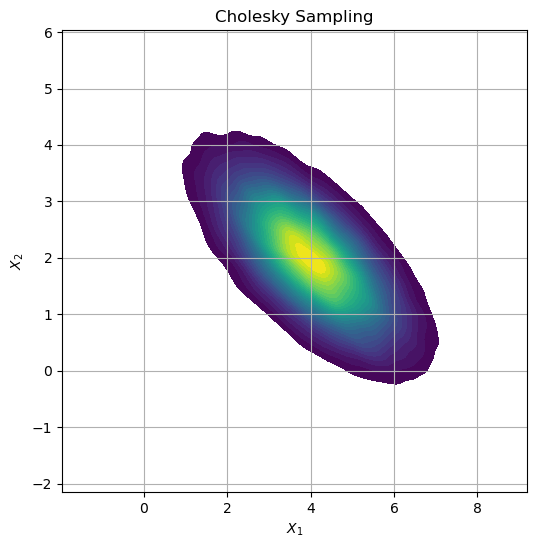

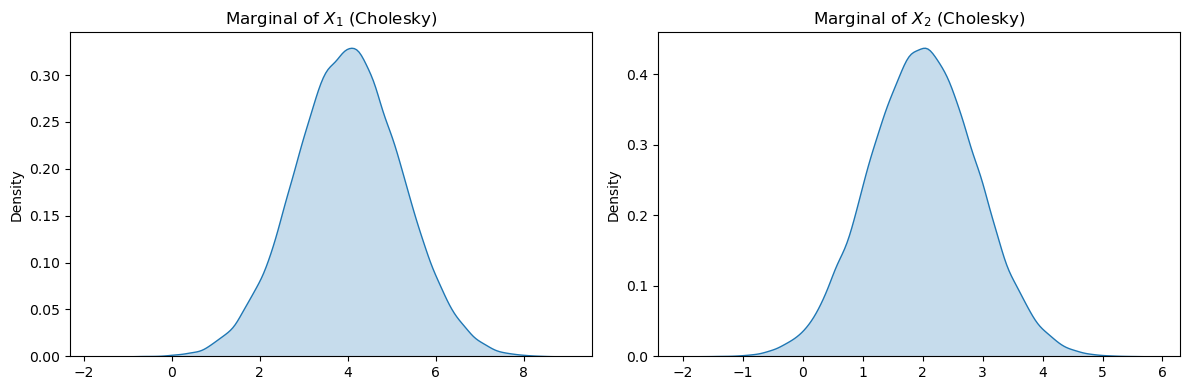

Cholesky Sampling 95% Credible Intervals:
  X1: [1.628, 6.373]
  X2: [0.249, 3.765]


In [5]:
# Cholesky decomposition of covariance matrix
eigenvalues = np.linalg.eigvals(sigma)
print(f"The eigenvalues are: {eigenvalues[0]:.3f}, {eigenvalues[1]:.3f} → Covariance matrix is positive definite.")

L = np.linalg.cholesky(sigma)
print("Verify Cholesky decomposition (Cov ≈ L·Lᵀ):")
print(np.round(sigma - L @ L.T, 6))  

# Sample u ~ N(0, I) and transform to X ~ N(μ, Σ)
u = np.random.normal(size=(50_000, 2))  # shape (n, 2)
samples_chol = mu + u @ L.T             # shape (n, 2)

# Extract x1, x2
x1_chol, x2_chol = samples_chol[:, 0], samples_chol[:, 1]

# KDE + joint contour plot
fig, ax = plt.subplots(figsize=(6, 6))
plot_joint_contour(samples_chol, "Cholesky Sampling", ax)
plt.show()

# Marginal histograms
plot_marginals(samples_chol, "Cholesky")

# Credible intervals
ci_x1_chol = credible_interval(x1_chol)
ci_x2_chol = credible_interval(x2_chol)

print("Cholesky Sampling 95% Credible Intervals:")
print(f"  X1: [{ci_x1_chol[0]:.3f}, {ci_x1_chol[1]:.3f}]")
print(f"  X2: [{ci_x2_chol[0]:.3f}, {ci_x2_chol[1]:.3f}]")


The Cholesky decomposition confirms that the covariance matrix is positive definite, allowing sampling from the target distribution by transforming standard normal samples.

**Cholesky Sampling 95% Credible Intervals:**

-  $ X_1 : [1.628,\ 6.373]$
- $ X_2 : [0.249,\ 3.765]$

These intervals are very close to those obtained from the analytical marginals, indicating that the Cholesky-based sampling accurately captures the distribution's spread.


### Metropolis-Hastings Sampling and Posterior Estimation


100%|██████████| 50000/50000 [00:05<00:00, 9945.47it/s] 


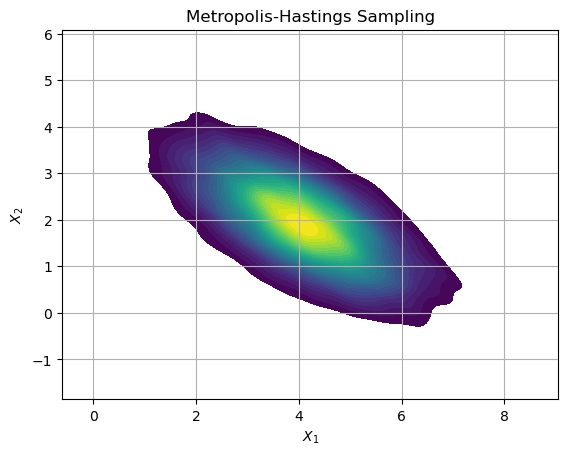

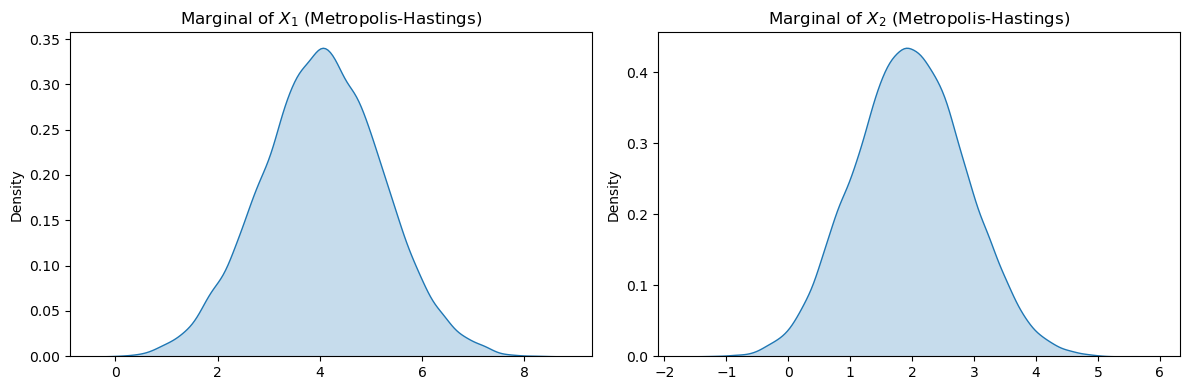

Metropolis-Hastings 95% Credible Intervals:
  X1: [1.713, 6.362]
  X2: [0.254, 3.734]


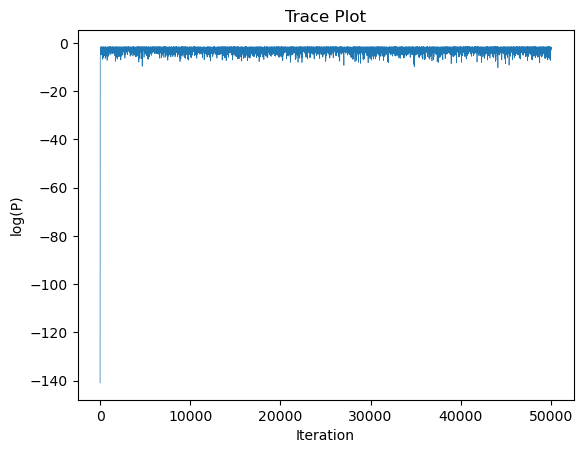

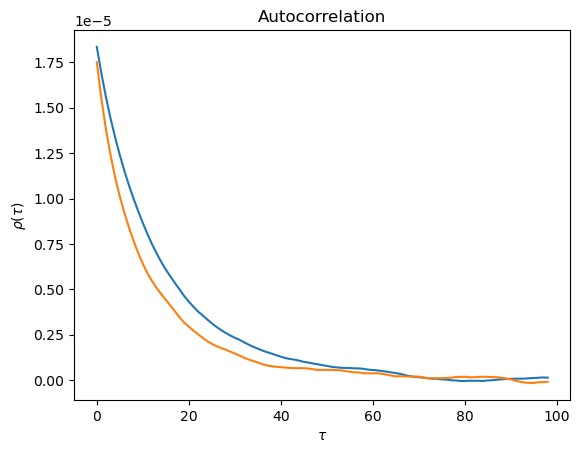

In [6]:
# MH Sampler Class
class MHsampler:
    def __init__(self):
        self.sigma = None
        self.uniform = uniform()

    def set_sigma(self, sigma):
        self.sigma = sigma
        self.proposal = multivariate_normal(cov=self.sigma * np.eye(2))

    def set_target(self, target):
        self.target = target

    def sample(self, x0, n):
        x = x0
        samples = []
        for i in tqdm(range(n)):
            self.proposal.mean = x
            x_new = self.proposal.rvs()
            acceptance = np.log(self.target.pdf(x_new)) - np.log(self.target.pdf(x))
            if np.log(self.uniform.rvs()) < acceptance:
                x = x_new
            samples.append(x)
        self.samples = np.array(samples)

    def autocorrelation(self, tau):
        n = len(self.samples)
        mean = np.mean(self.samples, axis=0)
        rho = (1 / (n - tau)) * np.sum(
            (self.samples[:-tau] - mean) * (self.samples[tau:] - mean), axis=0
        ) / np.sum((self.samples[:-tau] - mean) ** 2, axis=0)
        return rho

    def autocorr_time(self):
        taus = np.arange(1, 100)
        rho = np.array([self.autocorrelation(tau) for tau in taus])
        self.rho = rho
        self.corr_time = 1 + 2 * np.sum(self.rho, axis=0)
        return self.rho, self.corr_time

    def final_samples(self, burn_in=100):
        return self.samples[burn_in::math.ceil(np.mean(self.corr_time)), :]

    def plot_autocorr(self):
        plt.plot(self.rho)
        plt.xlabel(r"$\tau$")
        plt.ylabel(r"$\rho(\tau)$")
        plt.title("Autocorrelation")

    def plot_trace(self):
        plt.plot(np.log(self.target.pdf(self.samples)), linewidth=0.5)
        plt.xlabel("Iteration")
        plt.ylabel("log(P)")
        plt.title("Trace Plot")


# Instantiate and run sampler
sampler = MHsampler()
sampler.set_sigma(np.array([0.5, 0.5]))
sampler.set_target(joint_mvn)
sampler.sample(x0=np.array([10, 10]), n=50_000)

# Burn-in and thinning
sampler.autocorr_time()
samples_mh = sampler.final_samples()

# Extract x1, x2
x1_mh, x2_mh = samples_mh[:, 0], samples_mh[:, 1]

# Plot joint and marginals
plot_joint_contour(samples_mh, "Metropolis-Hastings Sampling", plt.gca())
plt.show()
plot_marginals(samples_mh, "Metropolis-Hastings")

ci_x1_mh = credible_interval(x1_mh)
ci_x2_mh = credible_interval(x2_mh)

print("Metropolis-Hastings 95% Credible Intervals:")
print(f"  X1: [{ci_x1_mh[0]:.3f}, {ci_x1_mh[1]:.3f}]")
print(f"  X2: [{ci_x2_mh[0]:.3f}, {ci_x2_mh[1]:.3f}]")

# Trace + autocorr
sampler.plot_trace()
plt.show()
sampler.plot_autocorr()
plt.show()


The Metropolis-Hastings algorithm was used to draw samples from the bivariate Gaussian distribution. After burn-in and thinning based on autocorrelation, the estimated 95% credible intervals are:

- $ X_1 : [1.713, 6.362] $
- $ X_2 : [0.254, 3.734] $

These results are consistent with those from the true marginals and Cholesky-based sampling, confirming that the MH sampler effectively approximates the target distribution despite its dependence on a proposal and acceptance mechanism.


###  Gibbs Sampling for Bivariate Gaussian

100%|██████████| 50000/50000 [00:20<00:00, 2457.91it/s]


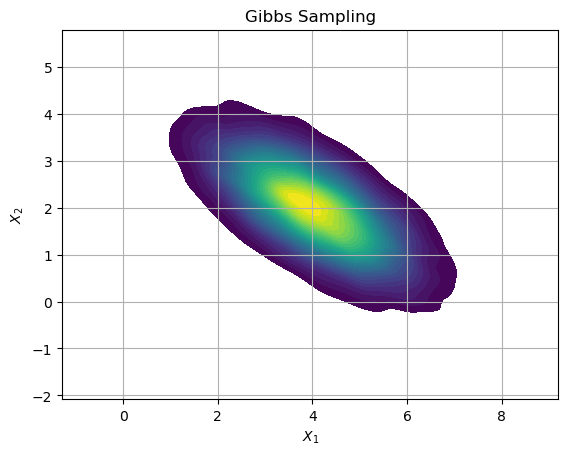

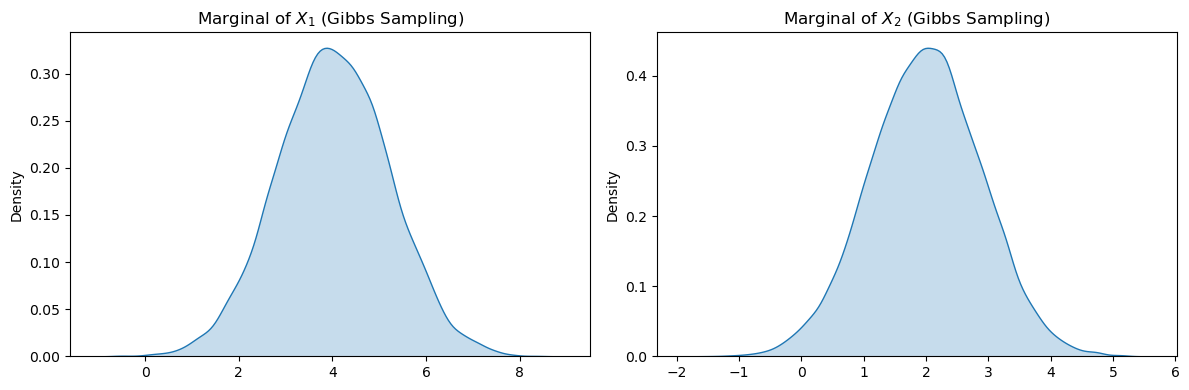

Gibbs Sampling 95% Credible Intervals:
  X1: [1.675, 6.346]
  X2: [0.211, 3.738]


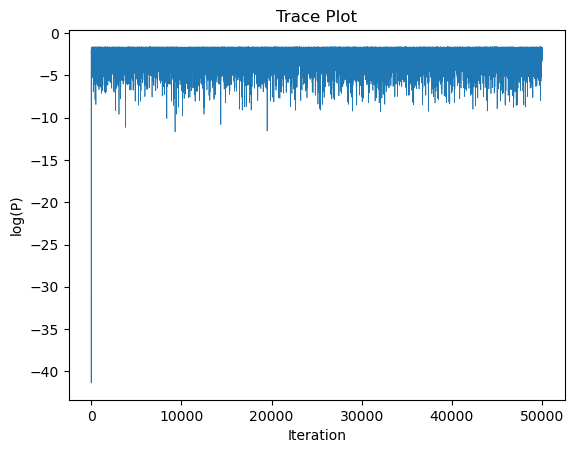

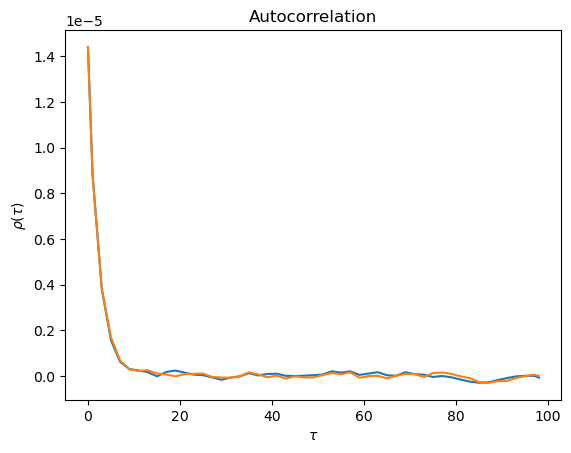

In [7]:
# Gibbs Sampler Class
class Gsampler:
    def __init__(self):
        self.uniform = uniform()

        # The proposal distributions are the conditional distributions
        self.proposal_x = cond_x
        self.proposal_y = cond_y
        
    def set_target(self, target):
        self.target = target
        
    def sample(self, x0, n):
        x = x0
        samples = [x0]
        for i in tqdm(range(n)):
            # Alternating between sampling x and y
            if i % 2 == 0:
                x[0] = self.proposal_x(given_y=x[1]).rvs()
            else:
                x[1] = self.proposal_y(given_x=x[0]).rvs()
            samples.append(x.copy())
        self.samples = np.array(samples)
        
    def autocorrelation(self, tau):
        n = len(self.samples)
        mean = np.mean(self.samples, axis=0)
        rho = (1 / (n - tau)) * np.sum(
            (self.samples[:-tau] - mean) * (self.samples[tau:] - mean), axis=0
        ) / np.sum((self.samples - mean) ** 2, axis=0)
        return rho
    
    def autocorr_time(self):
        taus = np.arange(1, 100)
        rho = np.array([self.autocorrelation(tau) for tau in taus])
        self.rho = rho
        self.corr_time = 1 + 2 * np.sum(self.rho, axis=0)
        return self.rho, self.corr_time
    
    def final_samples(self, burn_in=100):
        return self.samples[burn_in::math.ceil(np.mean(self.corr_time)), :]

    def plot_autocorr(self):
        plt.plot(self.rho)
        plt.xlabel(r"$\tau$")
        plt.ylabel(r"$\rho(\tau)$")
        plt.title("Autocorrelation")

    def plot_chain(self):
        plt.plot(self.samples[:, 0], self.samples[:, 1], linewidth=0.5)
        plt.xlabel(r"$X_1$")
        plt.ylabel(r"$X_2$")
        plt.title("Gibbs Sampler Chain")
        
    def plot_trace(self):
        plt.plot(np.log(self.target.pdf(self.samples)), linewidth=0.5)
        plt.xlabel("Iteration")
        plt.ylabel("log(P)")
        plt.title("Trace Plot")

# Instantiate and run the Gibbs sampler
sampler = Gsampler()
sampler.set_target(joint_mvn)
sampler.sample(x0=np.array([10., 10.]), n=50_000)

# Burn-in and thinning
sampler.autocorr_time()
samples_gibbs = sampler.final_samples()

# Extract x1, x2
x1_gibbs, x2_gibbs = samples_gibbs[:, 0], samples_gibbs[:, 1]

# Plot joint and marginals
plot_joint_contour(samples_gibbs, "Gibbs Sampling", plt.gca())
plt.show()
plot_marginals(samples_gibbs, "Gibbs Sampling")

ci_x1_gibbs = credible_interval(x1_gibbs)
ci_x2_gibbs = credible_interval(x2_gibbs)

print("Gibbs Sampling 95% Credible Intervals:")
print(f"  X1: [{ci_x1_gibbs[0]:.3f}, {ci_x1_gibbs[1]:.3f}]")
print(f"  X2: [{ci_x2_gibbs[0]:.3f}, {ci_x2_gibbs[1]:.3f}]")

# Optional: trace + autocorr
sampler.plot_trace()
plt.show()
sampler.plot_autocorr()
plt.show()


The Gibbs sampler was implemented using the exact conditional distributions of the bivariate Gaussian. By alternating between $ X_1 \mid X_2$ and $X_2 \mid X_1$, the sampler efficiently explores the joint distribution.

The estimated 95% credible intervals are:

- $ X_1: [1.675, 6.346] $ 
- $ X_2: [0.211, 3.738] $

These intervals closely match the theoretical marginals and results from Cholesky and Metropolis-Hastings sampling, confirming that Gibbs sampling provides accurate posterior estimates in this case.
